# RetinaNet for Object Detetion with COCO 2017 Dataset

[RetinaNet](https://arxiv.org/abs/1708.02002) is a one-stage object detector, named for its dense sampling of object locations in an input image. Its design features an efficient in-network feature pyramid and use of anchor boxes. To address the one-stage object detection scenario in which there is an extreme imbalance between foreground and background classes during training, the authors also intoduced the Focal Loss for classification. We will walk through some of the implementation details.

In [1]:
import os
import tempfile
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import fastestimator as fe
from fastestimator.architecture.retinanet import PredictBox, RetinaNet, _get_fpn_anchor_box, _get_target
from fastestimator.dataset.mscoco import load_data
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox
from fastestimator.op.tensorop import Loss, ModelOp, Pad, Rescale
from fastestimator.schedule import LRSchedule
from fastestimator.trace import LRController, MeanAvgPrecision, ModelSaver

In [2]:
# parameters
BATCH_SIZE = 8
EPOCHS = 12
INPUT_SHAPE = (512, 512, 3)
NUM_CLASSES = 90
PAD = 1262
MODEL_SAVE_DIR = tempfile.mkdtemp()
STEPS_PER_EPOCH = 1
VALIDATION_STEPS = None

## Download COCO Dataset

We will download the COCO 2017 dataset. The whole dataset is about 20 GB. 

In [3]:
train_csv, val_csv, path = load_data()

For train and validation data, we have

* Train: 117266 images
* Validation: 4952 images

There are 90 classes in the COCO dataset; they are:

In [4]:
class_map = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush'
}

## Step 1: Create Data Pipeline

First, we define the classes we will need for generating TFRecords.

In [5]:
class String2List(NumpyOp):
    """Convert string into numpy array.
    
    For example, '[1, 2, 3]' will become np.array([1, 2, 3]).
    """
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [6]:
class FlipImageAndBbox(NumpyOp):
    """Augment image and its associated bounding boxes with horizontally flipped ones.
    """
    def forward(self, data, state):
        img, x1, y1, w, h, obj_label, ids = data
        if state["mode"] == "train":
            img_flipped = cv2.flip(img, 1)
            x1_flipped = img.shape[1] - x1 - w
            augmented_data = [
                np.array([img, img_flipped]),
                np.array([x1, x1_flipped]),
                np.array([y1, y1]),
                np.array([w, w]),
                np.array([h, h]),
                np.array([obj_label, obj_label]),
                np.array([ids, ids])
            ]
        else:
            augmented_data = [
                np.array([img]),
                np.array([x1]),
                np.array([y1]),
                np.array([w]),
                np.array([h]),
                np.array([obj_label]),
                np.array([ids])
            ]
        return augmented_data

In [7]:
class GenerateTarget(NumpyOp):
    """Generate classification and regression targets in relative coordinates.
    """
    def __init__(self, input_shape, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = _get_fpn_anchor_box(input_shape=input_shape)

    def forward(self, data, state):
        obj_label, x1, y1, width, height = data
        num_example = obj_label.shape[0]
        cls_gt = []
        x1_gt = []
        y1_gt = []
        w_gt = []
        h_gt = []
        for idx in range(num_example):
            c, x, y, w, h = _get_target(self.anchorbox, obj_label[idx], x1[idx], y1[idx], width[idx], height[idx])
            cls_gt.append(c)
            x1_gt.append(x)
            y1_gt.append(y)
            w_gt.append(w)
            h_gt.append(h)
        target = [np.array(cls_gt), np.array(x1_gt), np.array(y1_gt), np.array(w_gt), np.array(h_gt)]
        return target

### TFRecord Writer

We first read the metadata from csv files, then we generate TFRecords:
1. Read image with `ImageReader` class.
2. Read ground truth bounding boxes' labels and coordinates with `String2List` class.
3. Resize image and its assocoated bounding boxes with `ResizeImageAndBbox` class.
4. Data augmentation using horozontal flip with `FlipImageAndBbox` class.
5. Generate classificaiton and regression target with `GenerateTarget` class.

For 512 by 512 image size, it takes about 50 GB of the disk space.

In [8]:
writer = fe.RecordWriter(
    save_dir=os.path.join(path, "retinanet_coco_512"),
    train_data=train_csv,
    validation_data=val_csv,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        String2List(inputs=["x1", "y1", "width", "height", "obj_label"],
                    outputs=["x1", "y1", "width", "height", "obj_label"]),
        ResizeImageAndBbox(target_size=INPUT_SHAPE[0:2],
                           keep_ratio=True,
                           inputs=["image", "x1", "y1", "width", "height"],
                           outputs=["image", "x1", "y1", "width", "height"]),
        FlipImageAndBbox(inputs=["image", "x1", "y1", "width", "height", "obj_label", "id"],
                         outputs=["image", "x1", "y1", "width", "height", "obj_label", "id"]),
        GenerateTarget(input_shape=INPUT_SHAPE,
                       inputs=("obj_label", "x1", "y1", "width", "height"),
                       outputs=("cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt"))
    ],
    expand_dims=True,
    compression="GZIP",
    write_feature=[
        "image", "id", "cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width", "height"
    ])

### FastEstimator Pipeline

Once we have our record writer, we feed the record writer instance into `fe.pipeline`. `Rescale` class normalizes the images to between -1 and 1. The `PAD` parameter for `Pad` class is pre-calculated. This `PAD` parameter is the maximum number of positive (foreground) anchor boxes in one image for the whole COCO dataset.

In [9]:
pipeline = fe.Pipeline(
    batch_size=BATCH_SIZE,
    data=writer,
    ops=[
        Rescale(inputs="image", outputs="image"),
        Pad(padded_shape=[PAD],
            inputs=["x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width", "height"],
            outputs=["x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width", "height"])
    ])

### Visuzlize Images from Batch

In [10]:
batch_data = pipeline.show_results(mode='eval', num_steps=6)

FastEstimator: Reading non-empty directory: /home/hsiming/fastestimator_data/MSCOCO2017/retinanet_coco_512
FastEstimator: Found 117266 examples for train in /home/hsiming/fastestimator_data/MSCOCO2017/retinanet_coco_512/train_summary0.json
FastEstimator: Found 4952 examples for eval in /home/hsiming/fastestimator_data/MSCOCO2017/retinanet_coco_512/eval_summary0.json


Let's check the training batch at step = 6

In [11]:
step_index = 5

id = 321333


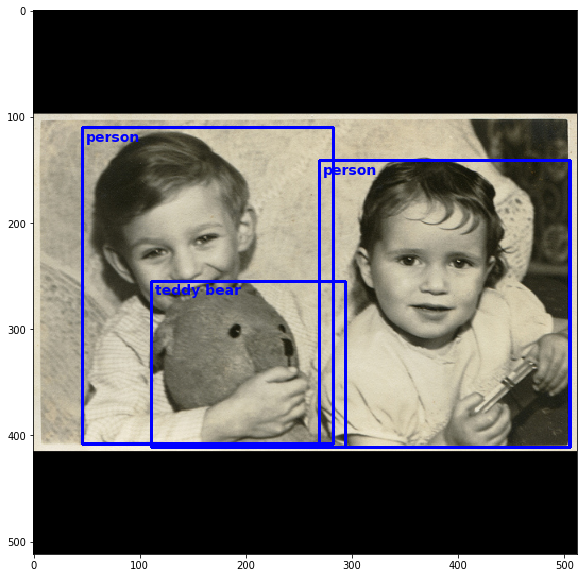

In [12]:
image_index = 7

img = batch_data[step_index]['image'].numpy()[image_index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

labels = batch_data[step_index]['obj_label'].numpy()[image_index]
keep = labels > 0
labels = labels[keep]
x1 = batch_data[step_index]['x1'].numpy()[image_index][keep]
y1 = batch_data[step_index]['y1'].numpy()[image_index][keep]
w = batch_data[step_index]['width'].numpy()[image_index][keep]
h = batch_data[step_index]['height'].numpy()[image_index][keep]
x2 = x1 + w
y2 = y1 + h

fig, ax = plt.subplots(figsize=(10, 10))
for j in range(len(x1)):
    cv2.rectangle(img, (x1[j], y1[j]), (x2[j], y2[j]), (0, 0, 255), 2)
    ax.text(x1[j] + 3, y1[j] + 12, class_map[labels[j]], color=(0, 0, 1), fontsize=14, fontweight='bold')

ax.imshow(img)

print("id = {}".format(batch_data[step_index]['id'].numpy()[image_index]))

## Step 2: Create Network

### Focal Loss for Classification and Smooth L1 Loss for Regression

The Focal Loss is designed to address the one-stage object detection scenario in which there is an extreme imbalance between foreground and background classes during training (e.g., 1:1000).

The Focal Loss has the form:

$- \alpha (1-p_t)^\gamma \log(p_t)$

where the $-\log(p_t)$ part is the cross entropy for binary classification. $\alpha$ and $\gamma$ are hyperparameters. The $(1-p_t)^\gamma$ part is a modulating factor. Intuitively, the modulating factor reduces the loss contribution from easy examples and extends the range in which an example receives low loss.

In [13]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, alpha=0.25, gamma=2.0):
        # cls_gt_example shape: [A], cls_pred_example shape: [A, K]
        num_classes = cls_pred_example.shape[-1]
        # gather the objects and background, discard the rest
        anchor_obj_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        anchor_obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, -1))
        anchor_obj_count = tf.cast(tf.shape(anchor_obj_idx)[0], tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, anchor_obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, anchor_obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / anchor_obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss, anchor_obj_idx

    def smooth_l1(self, loc_gt_example, loc_pred_example, anchor_obj_idx, beta=0.1):
        # loc_gt is padded x 4, loc_pred is #num_anchor x 4
        loc_pred = tf.gather_nd(loc_pred_example, anchor_obj_idx)  #anchor_obj_count x 4
        anchor_obj_count = tf.shape(loc_pred)[0]
        loc_gt = loc_gt_example[:anchor_obj_count]  #anchor_obj_count x 4
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        cond = tf.less(loc_diff, beta)
        smooth_l1_loss = tf.where(cond, 0.5 * loc_diff**2 / beta, loc_diff - 0.5 * beta)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / tf.cast(anchor_obj_count, tf.float32)
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, x1_gt, y1_gt, w_gt, h_gt, cls_pred, loc_pred = data
        local_batch_size = state["local_batch_size"]
        focal_loss = []
        l1_loss = []
        total_loss = []
        for idx in range(local_batch_size):
            cls_gt_example = cls_gt[idx]
            x1_gt_example = x1_gt[idx]
            y1_gt_example = y1_gt[idx]
            w_gt_example = w_gt[idx]
            h_gt_example = h_gt[idx]
            loc_gt_example = tf.transpose(tf.stack([x1_gt_example, y1_gt_example, w_gt_example, h_gt_example]))
            cls_pred_example = cls_pred[idx]
            loc_pred_example = loc_pred[idx]
            focal_loss_example, anchor_obj_idx = self.focal_loss(cls_gt_example, cls_pred_example)
            smooth_l1_loss_example = self.smooth_l1(loc_gt_example, loc_pred_example, anchor_obj_idx)
            focal_loss.append(focal_loss_example)
            l1_loss.append(smooth_l1_loss_example)
        focal_loss = tf.stack(focal_loss)
        l1_loss = tf.stack(l1_loss)
        total_loss = focal_loss + l1_loss
        return total_loss, focal_loss, l1_loss

### Build Network with Model, Optimizer, and Loss

In [14]:
model = fe.build(model_def=lambda: RetinaNet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES),
                 model_name="retinanet",
                 optimizer=tf.optimizers.SGD(momentum=0.9),
                 loss_name="total_loss")
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["cls_pred", "loc_pred"]),
    RetinaLoss(inputs=("cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt", "cls_pred", "loc_pred"),
               outputs=("total_loss", "focal_loss", "l1_loss")),
    PredictBox(inputs=["cls_pred", "loc_pred", "obj_label", "x1", "y1", "width", "height"],
               outputs=("pred", "gt"),
               mode="eval",
               input_shape=INPUT_SHAPE)
])

## Create Estimator

The original RetinaNet was trained using SGD over 8 GPUs with a total of 16 images per minibatch (2 images per GPU) for 90k iterations, with an initial learning rate of 0.01, which is then divided by 10 at 60k and again at 80k iterations.

For our current implementation, in every two steps we train the image and its horozontal flipped version. This is differnt from the original implementation where they randomly flipped the image being trained. This is why our learning rate scheduler reduces learning rate at 120k and 160 k iterations. 

For single GPU training, our batch size is 8, which is half the batch size of the original training. This why the returning learing rate is divided by 2. 

In [15]:
class MyLRSchedule(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        if current_step_or_epoch < 2000:
            lr = (0.01 - 0.0002) / 2000 * current_step_or_epoch + 0.0002
        elif current_step_or_epoch < 120000:
            lr = 0.01
        elif current_step_or_epoch < 160000:
            lr = 0.001
        else:
            lr = 0.0001
        return lr / 2  # original batch_size 16, for 512 we have batch_size 8

In [16]:
# prepare estimator
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    epochs=EPOCHS,
    traces=[
        MeanAvgPrecision(NUM_CLASSES, INPUT_SHAPE, 'pred', 'gt', output_name=("mAP", "AP50", "AP75")),
        ModelSaver(model_name="retinanet", save_dir=MODEL_SAVE_DIR, save_best='mAP', save_best_mode='max'),
        LRController(model_name="retinanet", lr_schedule=MyLRSchedule(schedule_mode="step"))
    ],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS)

## Start Training

Training takes about 15 hours for 12 epochs on single V100 GPU. 

In [ ]:
estimator.fit()

## Inference Using Trained Model

First we load a trained model from `MODEL_PATH`.

In [18]:
MODEL_PATH = 'location_to_the_trained_model'

In [19]:
trained_model = load_model(MODEL_PATH, compile=False)

In [20]:
cls_pred, deltas = trained_model(batch_data[step_index]['image'])

The outputs are in relative coordinates, we need to convert the outputs back to the original image coordinates. This is accomplished by `PredictBox`.

In [21]:
predict_box = PredictBox(inputs=["cls_pred", "loc_pred", "obj_label", "x1", "y1", "width", "height"],
                         outputs=("pred", "gt"),
                         mode="eval",
                         input_shape=INPUT_SHAPE)

In [22]:
tf_pred, tf_gt = predict_box.forward([cls_pred, deltas, batch_data[step_index]['obj_label'], batch_data[step_index]['x1'], batch_data[step_index]['y1'], batch_data[step_index]['width'], batch_data[step_index]['height']], {'local_batch_size': 8})

### Display Predictions

id = 321333


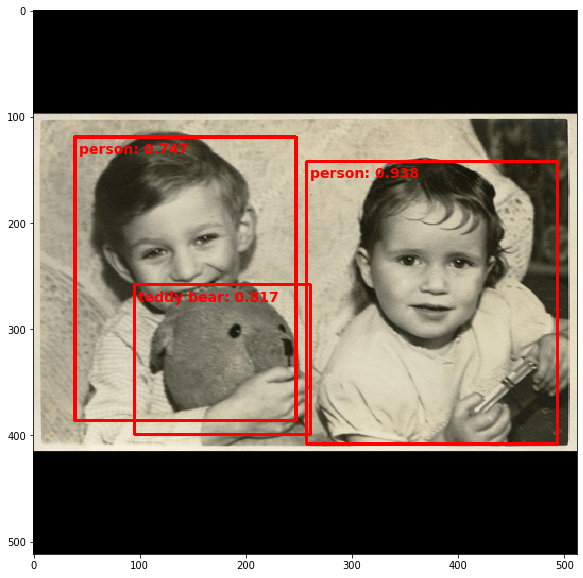

In [24]:
keep = tf.where(tf.equal(tf_pred[:, 0], image_index), True, False)
keep_gt = tf.where(tf.equal(tf_gt[:, 0], image_index), True, False)

x1 = tf_pred[keep][:, 1].numpy()
y1 = tf_pred[keep][:, 2].numpy()
w = tf_pred[keep][:, 3].numpy()
h = tf_pred[keep][:, 4].numpy()
x2 = x1 + w
y2 = y1 + h
labels = tf_pred[keep][:, 5].numpy()
scores = tf_pred[keep][:, 6].numpy()

# only display predictions with score > 0.5
keep_score = scores > 0.5
x1 = x1[keep_score]
y1 = y1[keep_score]
x2 = x2[keep_score]
y2 = y2[keep_score]
final_labels = [class_map[label] for label in labels[keep_score]]
final_scores = scores[keep_score]

img = batch_data[step_index]['image'].numpy()[image_index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(final_scores)):#range(len(x1_gt)):  #range(len(final_scores)):
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)
    ax.text(x1[i] + 3, y1[i] + 15, '{}: {:.3f}'.format(class_map[labels[i]], final_scores[i]), color=(1, 0, 0), fontsize=14, fontweight='bold')

ax.imshow(img)

print("id = {}".format(batch_data[step_index]['id'].numpy()[image_index]))